In [1]:
suppressMessages(library(ArchR))
suppressMessages(library(Seurat))
suppressMessages(library(Signac))
suppressMessages(library(harmony))
suppressMessages(library(dplyr))
suppressMessages(library(cowplot))

In [2]:
set.seed(42)

In [3]:
proj <- loadArchRProject("../data/snATAC", showLogo = FALSE)

Successfully loaded ArchRProject!



ArchR logging to : ArchRLogs/ArchR-plotEmbedding-4e2986e041975-Date-2021-12-06_Time-16-25-56.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-4e2986e041975-Date-2021-12-06_Time-16-25-56.log



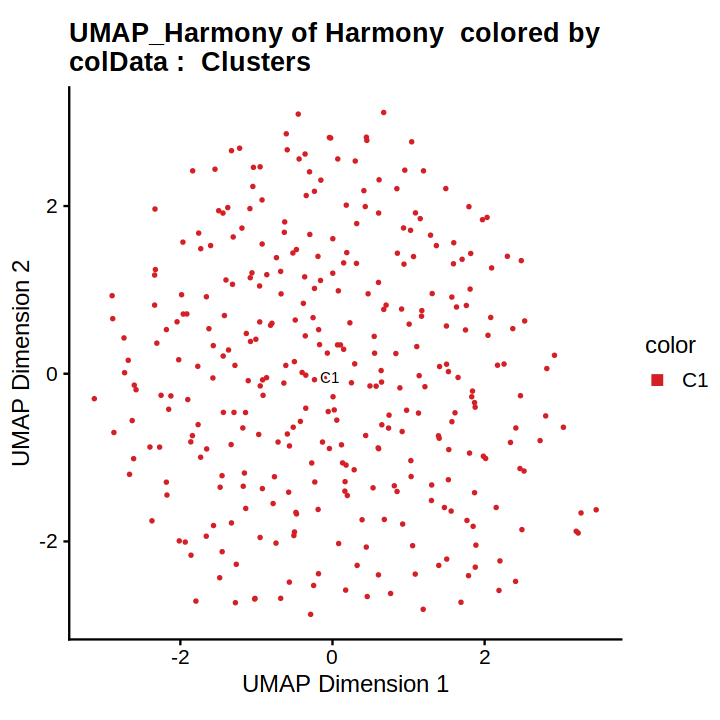

In [4]:
p1 <- plotEmbedding(ArchRProj = proj, 
              colorBy = "cellColData", 
              name = "Clusters", embedding = "UMAP_Harmony",plotAs = "points",
                   size = 0.5, labelAsFactors = FALSE, rastr = FALSE) +
    theme_cowplot()

options(repr.plot.height = 6, repr.plot.width = 6)

p1

In [5]:
table(proj@cellColData$Clusters)


 C1 
335 

In [6]:
peak_counts <- readRDS("../data/snATAC/PeakMatrix.Rds")
dim(peak_counts)

[1] 521947    335

In [7]:
## cluster 1-3 seems to be outlier, we here removed it from downstream analysis
metadata <- as.data.frame(proj@cellColData) %>%
    subset(., select = c("Sample", "Clusters", "region", "patient", "patient_region_id", "patient_group")) #%>%
    #subset(., Clusters %in% c("C4", "C5", "C6", "C7", "C8") )


head(metadata)

peak_counts_sub <- peak_counts[, rownames(metadata)]

dim(peak_counts_sub)

,Sample,Clusters,region,patient,patient_region_id,patient_group
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
CK171#CGTGGCATCTACTTTG-1,CK171,C1,RZ/BZ,P2,RZ/BZ_P2,group_1
CK171#GAGACTTAGGTCGGTA-1,CK171,C1,RZ/BZ,P2,RZ/BZ_P2,group_1
CK171#TGGCAATTCCTCAAGA-1,CK171,C1,RZ/BZ,P2,RZ/BZ_P2,group_1
CK171#GAGGATGGTTGTGAGG-1,CK171,C1,RZ/BZ,P2,RZ/BZ_P2,group_1
CK171#TCGCCTATCAAGAGGC-1,CK171,C1,RZ/BZ,P2,RZ/BZ_P2,group_1
CK171#TGGAAGGAGATAGGTT-1,CK171,C1,RZ/BZ,P2,RZ/BZ_P2,group_1


[1] 521947    335

In [8]:
table(metadata$Clusters)


 C1 
335 

In [9]:
chrom_assay <- CreateChromatinAssay(
  counts = peak_counts_sub,
  sep = c("_", "_"),
  min.cells = 5
)

obj.atac <- CreateSeuratObject(
  counts = chrom_assay,
  assay = "peaks",
  meta.data = metadata,
  names.field = 1, 
  names.delim = "#")

obj.atac

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from peaks to peaks_”


An object of class Seurat 
91725 features across 335 samples within 1 assay 
Active assay: peaks (91725 features, 0 variable features)

In [10]:
## add dimension reduced matrix
harmony_matDR <- proj@reducedDims$Harmony$matDR
colnames(harmony_matDR) <- paste0("Harmony_", 1:ncol(harmony_matDR))
harmony_matDR <- harmony_matDR[colnames(obj.atac), ]

obj.atac[["harmony"]] <- CreateDimReducObject(embeddings = harmony_matDR,
                                             assay = DefaultAssay(obj.atac),
                                             key = "Harmony_")

embedding <- proj@embeddings$UMAP_Harmony$df
colnames(embedding) <- paste0("UMAP_", 1:ncol(embedding))
embedding <- embedding[colnames(obj.atac), ]

#head(embedding)
obj.atac[["umap"]] <- CreateDimReducObject(embeddings = as.matrix(embedding),
                                             assay = "peaks",
                                             key = "UMAP_")

In [11]:
obj.atac <- RunUMAP(obj.atac, 
               dims = 1:30, 
               reduction = 'harmony',
               reduction.name = "umap_harmony",
               reduction.ke = 'umapharmony_',
              verbose = FALSE,
                   min.dist = 0.4)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


In [12]:
cols.clusters <- ArchR::paletteDiscrete(metadata$Clusters)

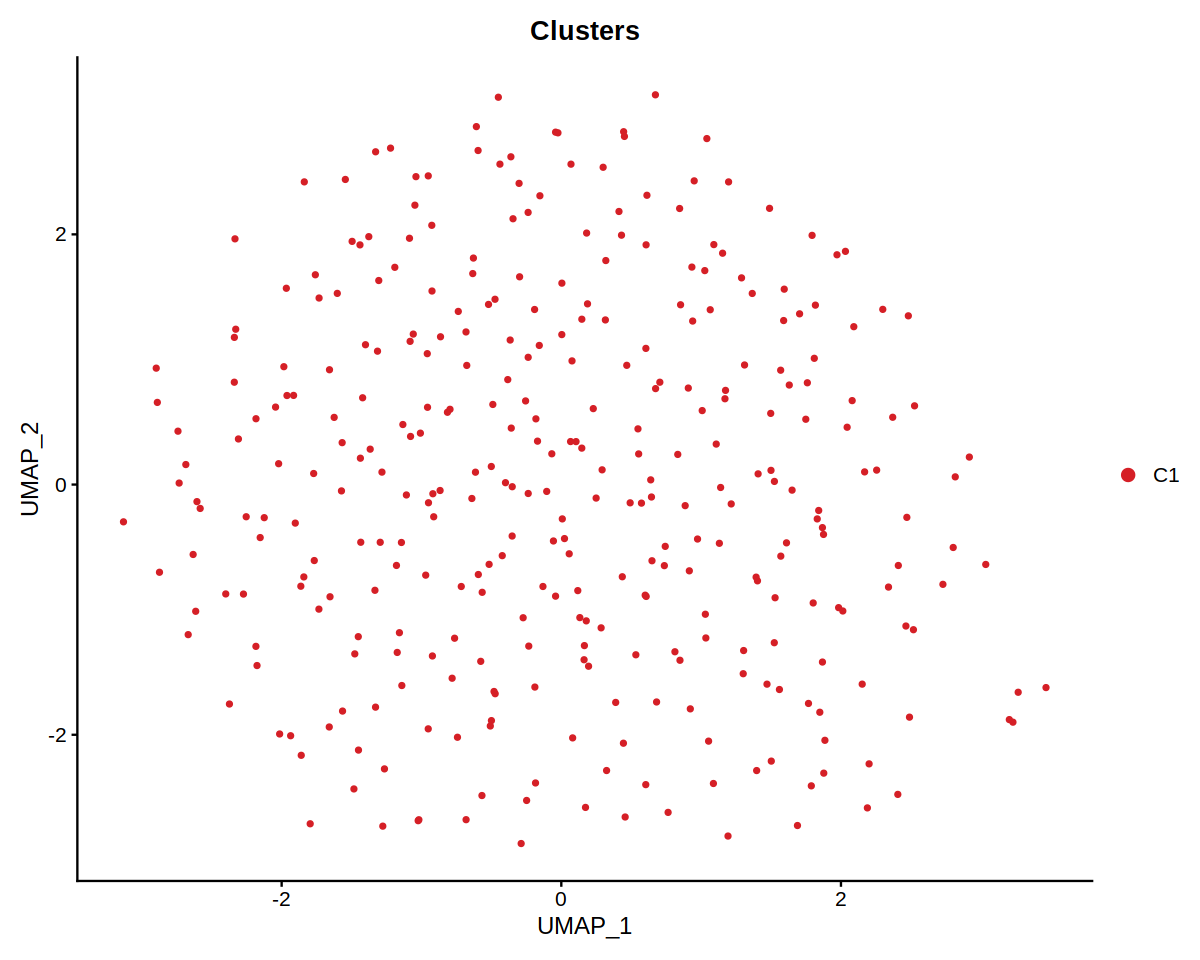

In [13]:
options(repr.plot.height = 8, repr.plot.width = 10)
p1 <- DimPlot(obj.atac, group.by = "Clusters", pt.size = 1, cols = cols.clusters)

p1

In [14]:
## load snRNA-seq data
obj.rna <- readRDS("../data/snRNA/snRNA.rds")
obj.rna

An object of class Seurat 
29126 features across 2172 samples within 1 assay 
Active assay: RNA (29126 features, 2000 variable features)
 4 dimensional reductions calculated: pca, harmony, umap_harmony, umap

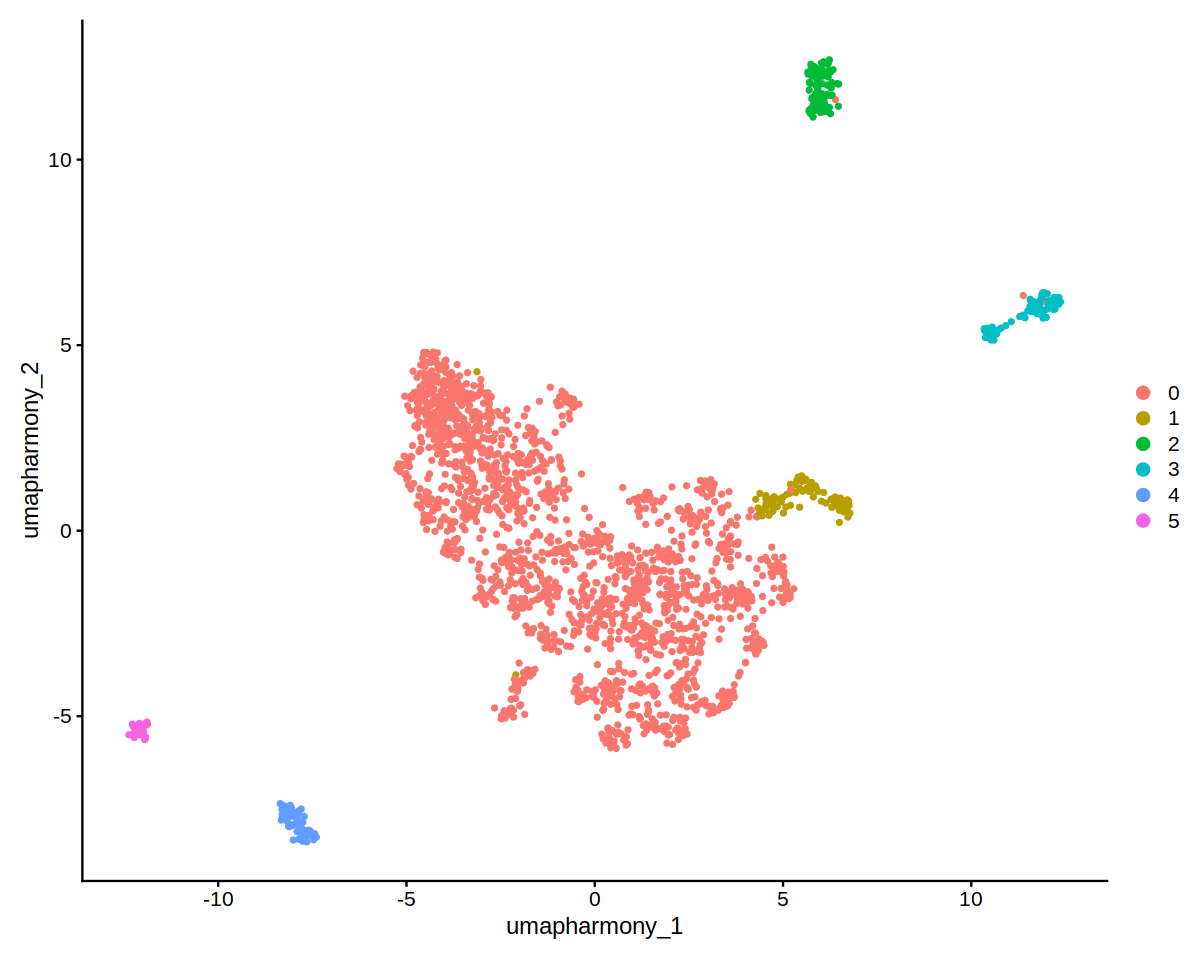

In [15]:
DimPlot(obj.rna, pt.size = 1, reduction = "umap_harmony")

In [ ]:
# suppressMessages(library(Nebulosa))

# options(repr.plot.height = 5, repr.plot.width = 15)

# p1 <- plot_density(obj.rna, features="KIT", reduction="umap_harmony")
# p2 <- plot_density(obj.rna, features="CPA3", reduction="umap_harmony")
# p3 <- plot_density(obj.rna, features="CLNK", reduction="umap_harmony")

# patchwork::wrap_plots(list(p1, p2, p3), nrow = 1)

In [ ]:
# obj.rna <- subset(obj.rna, orig.ident %in% df_cell_count$orig.ident)
# obj.rna

In [ ]:
## add gene activity score
gene.activities <- readRDS("../data/snATAC/GeneScoreMatrix.Rds")

dim(gene.activities)

gene.use <- intersect(rownames(gene.activities),
                     rownames(obj.rna))

length(gene.use)

obj.atac[['GeneActivity']] <- CreateAssayObject(counts = gene.activities[gene.use, colnames(obj.atac)])

DefaultAssay(obj.atac) <- "GeneActivity"

obj.atac <- obj.atac %>% 
        NormalizeData() %>%
        FindVariableFeatures() %>%
        ScaleData()

In [ ]:
transfer.anchors <- FindTransferAnchors(reference = obj.rna,
                                        query = obj.atac,
                                        features = gene.use,
                                        reference.assay = "RNA",
                                        query.assay = "GeneActivity",
                                        reduction = "cca")

In [ ]:
# note that we restrict the imputation to variable genes from scRNA-seq, but could impute the
# full transcriptome if we wanted to
refdata <- GetAssayData(obj.rna, assay = "RNA", slot = "data")[gene.use, ]

# refdata (input) contains a scRNA-seq expression matrix for the scRNA-seq cells. imputation
# (output) will contain an imputed scRNA-seq matrix for each of the ATAC cells
imputation <- TransferData(anchorset = transfer.anchors, 
                           refdata = refdata, 
                           weight.reduction = obj.atac[["harmony"]],
                           dims = 1:30)
obj.atac[["RNA"]] <- imputation

In [ ]:
DefaultAssay(obj.atac) <- "RNA"
obj.rna$tech <- "RNA"
obj.atac$tech <- "ATAC"
coembed <- merge(x = obj.atac, y = obj.rna)

In [ ]:
#Finally, we run PCA and UMAP on this combined object, to visualize the co-embedding of both datasets
coembed <- coembed %>%
    ScaleData(features = gene.use, do.scale = FALSE) %>%
    FindVariableFeatures() %>%
    RunPCA() %>%
    RunUMAP(dims = 1:30, verbose = FALSE)

In [ ]:
if(!dir.exists("../data/coembed")){
    dir.create("../data/coembed")
}

In [ ]:
saveRDS(obj.rna, file = "../data/snRNA/snRNA.Rds")
saveRDS(obj.atac, file = "../data/snATAC/snATAC.Rds")
saveRDS(coembed, file = "../data/coembed/coembed.Rds")

In [ ]:
sessionInfo()